In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Literal

import keras.layers as kl
import keras.models as km
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout,
                          GlobalAveragePooling2D, Input, MaxPooling2D,
                          RandomFlip, RandomRotation, RandomZoom, Rescaling,
                          Resizing)
from keras.metrics import (AUC, Accuracy, Precision, Recall,
                           TopKCategoricalAccuracy, CategoricalAccuracy)
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from livelossplot import PlotLossesKeras
from tensorflow import data as td

from src import load_dataset
from src.utils import get_model_path

# Data preparation

In [6]:
# разбиваем на train, val, test 80%/10%/10%

def split_stratified(dataset):
    from sklearn.model_selection import train_test_split

    data = tfds.as_numpy(dataset)
    X = np.array([example['image'] for example in data])
    fine_y = np.array([example['label'] for example in data])
    coarse_y = np.array([example['coarse_label'] for example in data])

    X_val, X_test, fine_y_val, fine_y_test, coarse_y_val, coarse_y_test = train_test_split(X, fine_y, coarse_y, test_size=0.5, stratify=fine_y, random_state=42)

    val_dataset = td.Dataset.from_tensor_slices({ "image": X_val, "label": fine_y_val, "coarse_label": coarse_y_val })
    test_dataset = td.Dataset.from_tensor_slices({ "image": X_test, "label": fine_y_test, "coarse_label": coarse_y_test })
    
    return val_dataset, test_dataset

(train_ds, test_ds), info = load_dataset(split=['train', 'test'])
val_ds, test_ds = split_stratified(test_ds)

In [7]:
# убираем лишние данные и переименовываем лейбл

@tf.function
def map_features(inputs):
    return {
        "image": inputs["image"],
        "fine": inputs["label"],
        "coarse": inputs["coarse_label"],
    }

train_ds = train_ds.map(map_features)
val_ds = val_ds.map(map_features)
test_ds = test_ds.map(map_features)

In [8]:
# энкодинг лейблов one-hot
def encode_labels(dataset: td.Dataset):
    def _create_encode_function():
        fine_layer = kl.IntegerLookup(
            vocabulary=np.arange(start=0, stop=100),
            max_tokens=100,
            num_oov_indices=0,
            vocabulary_dtype=tf.int64,
            output_mode="one_hot"
        )
        
        coarse_layer = kl.IntegerLookup(
            vocabulary=np.arange(start=0, stop=20),
            max_tokens=20,
            num_oov_indices=0,
            vocabulary_dtype=tf.int64,
            output_mode="one_hot"
        )

        return tf.function(
            lambda feature: {
                'image': feature['image'],
                'coarse': tf.cast(coarse_layer(feature['coarse']), tf.uint8),
                'fine': tf.cast(fine_layer(feature['fine']), tf.uint8),
            }
        )

    dataset = dataset.map(_create_encode_function(), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

train_ds = encode_labels(train_ds)
val_ds = encode_labels(val_ds)
test_ds = encode_labels(test_ds)

In [9]:
def augment_images(dataset: tf.data.Dataset) -> tf.data.Dataset:    
    augment_layer = km.Sequential(
        [
            RandomFlip("horizontal"),
            RandomRotation(factor=0.05),
            RandomZoom(height_factor=0.1, width_factor=0.1),
        ]
    )

    def augment(inputs):
        return {
            **inputs,
            'image': augment_layer(tf.cast(inputs['image'], tf.float32))
        }

    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset


train_ds = augment_images(train_ds)
val_ds = augment_images(val_ds)
test_ds = augment_images(test_ds)

In [10]:
def shuffle_batch_prefetch(dataset: td.Dataset, batch_size: int = 64):
    dataset = dataset.shuffle(dataset.cardinality())
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


train_ds = shuffle_batch_prefetch(train_ds)
val_ds = shuffle_batch_prefetch(val_ds)
test_ds = shuffle_batch_prefetch(test_ds)

In [11]:
# разделение на fine и coarse
def select_label(dataset: td.Dataset, label: Literal["fine", "coarse"] ='fine'):
    @tf.function
    def map_to_tuple(inputs):
        return (inputs["image"], inputs[label])
    
    return dataset.map(map_to_tuple)

In [9]:
select_label(train_ds, "coarse")

<_MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.uint8, name=None))>

# Training

## Объявление модели и колбеков

In [30]:
def build_model(num_classes: int) -> km.Model:
    model = km.Sequential()

    model.add(Input(shape=(32, 32, 3)))
    model.add(Rescaling(scale=1.0 / 255))

    model.add(Conv2D(128, (3, 3), padding="same", activation="elu"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation="elu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

    model.add(Conv2D(256, (3, 3), padding="same", activation="elu"))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation="elu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

    model.add(Conv2D(384, (3, 3), padding="same", activation="elu"))
    model.add(BatchNormalization())
    model.add(Conv2D(384, (3, 3), activation="elu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(1024, activation="elu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation="softmax"))

    return model


def compile_model(model: km.Model, learning_rate = 0.0005, metrics = None):
    if metrics is None:
        metrics = ["categorical_accuracy"]
    
    # lr_schedule = ExponentialDecay(
    #     0.0005, decay_steps=5000, decay_rate=0.8, staircase=False
    # )

    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=metrics,
    )    

    return model

In [31]:
early_stop_loss = EarlyStopping(
    monitor="val_loss",
    mode="min",
    min_delta=0.001,
    verbose=1,
    patience=10,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    min_delta=0.0001
)

checkpoint_filepath = '/tmp/checkpoints/weights.{epoch:02d}.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq=10
)

def get_callbacks():
    return [
        # model_checkpoint_callback,
        reduce_lr,
        early_stop_loss,
        PlotLossesKeras(),
    ]

## Coarse

### Train

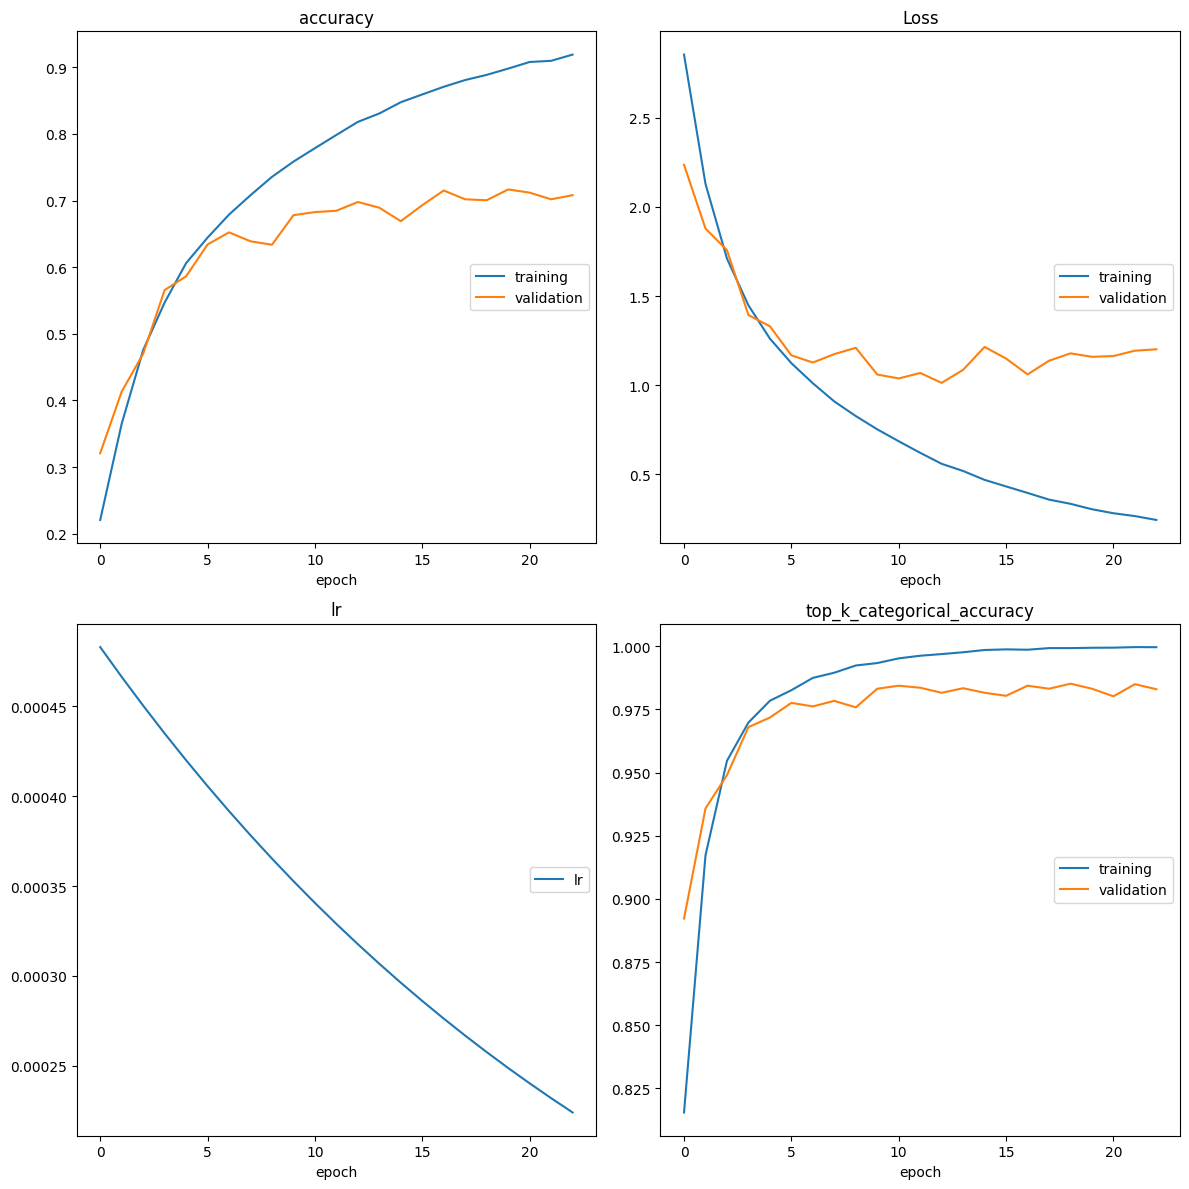

accuracy
	training         	 (min:    0.221, max:    0.919, cur:    0.919)
	validation       	 (min:    0.321, max:    0.717, cur:    0.708)
Loss
	training         	 (min:    0.245, max:    2.854, cur:    0.245)
	validation       	 (min:    1.014, max:    2.236, cur:    1.202)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
top_k_categorical_accuracy
	training         	 (min:    0.815, max:    1.000, cur:    1.000)
	validation       	 (min:    0.892, max:    0.985, cur:    0.983)
782/782 [==============================] - 94s 43ms/step - loss: 0.2450 - accuracy: 0.9190 - top_k_categorical_accuracy: 0.9996 - val_loss: 1.2019 - val_accuracy: 0.7080 - val_top_k_categorical_accuracy: 0.9830 - lr: 2.2407e-04
Epoch 23: early stopping


In [74]:
coarse_model = build_model(20)
coarse_model = compile_model(coarse_model)

coarse_model_history = coarse_model.fit(
    select_label(train_ds, "coarse"),
    validation_data=select_label(val_ds, "coarse"),
    epochs=100,
    callbacks=get_callbacks()
)

In [75]:
coarse_model.save(get_model_path("coarse"))

### Evaluate

In [18]:
coarse_model: km.Model = km.load_model(get_model_path("coarse"))

In [19]:
metrics = coarse_model.evaluate(select_label(test_ds, "coarse"))
for metric, value in zip(coarse_model.metrics_names, metrics):
    print(f"{metric}: {value}")

79/79 [==============================] - 8s 16ms/step - loss: 0.9854 - accuracy: 0.7110 - top_k_categorical_accuracy: 0.9862
loss: 0.9854312539100647
accuracy: 0.7110000252723694
top_k_categorical_accuracy: 0.9861999750137329


## Fine

### Train

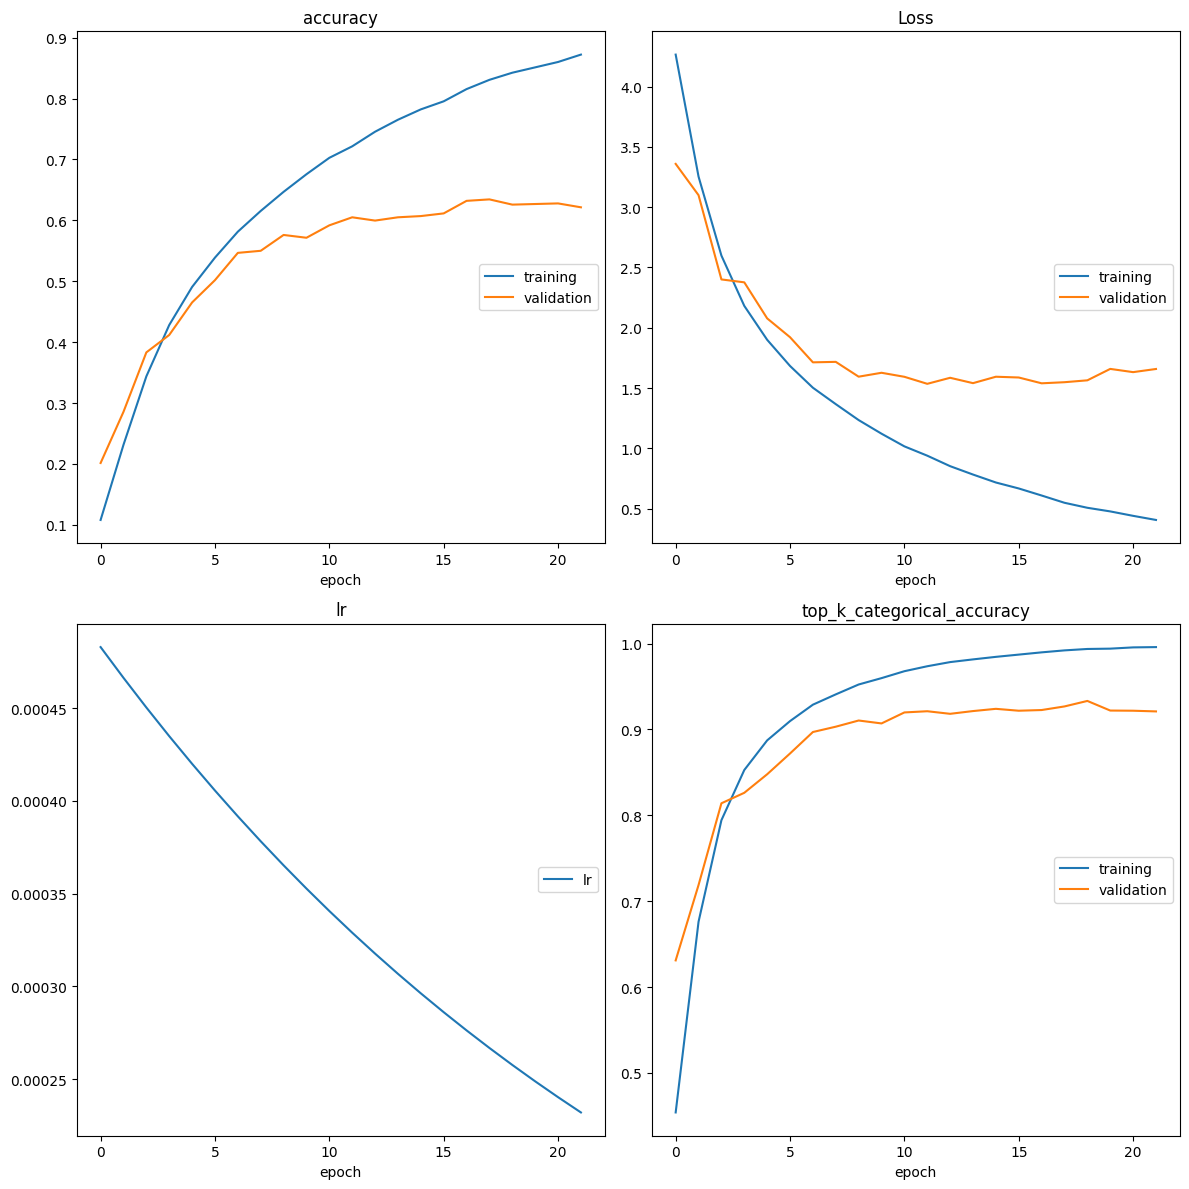

accuracy
	training         	 (min:    0.108, max:    0.872, cur:    0.872)
	validation       	 (min:    0.202, max:    0.634, cur:    0.621)
Loss
	training         	 (min:    0.407, max:    4.265, cur:    0.407)
	validation       	 (min:    1.536, max:    3.359, cur:    1.659)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
top_k_categorical_accuracy
	training         	 (min:    0.454, max:    0.996, cur:    0.996)
	validation       	 (min:    0.631, max:    0.933, cur:    0.921)
782/782 [==============================] - 95s 43ms/step - loss: 0.4071 - accuracy: 0.8721 - top_k_categorical_accuracy: 0.9959 - val_loss: 1.6586 - val_accuracy: 0.6214 - val_top_k_categorical_accuracy: 0.9210 - lr: 2.3203e-04
Epoch 22: early stopping


In [76]:
fine_model = build_model(100)
fine_model = compile_model(fine_model)

fine_model_history = fine_model.fit(
    select_label(train_ds, "fine"),
    validation_data=select_label(val_ds, "fine"),
    epochs=100,
    callbacks=get_callbacks()
)

In [77]:
fine_model.save(get_model_path("fine"))

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluate

In [4]:
fine_model: km.Model = km.load_model(get_model_path("fine"))

In [16]:
metrics = fine_model.evaluate(select_label(test_ds, "fine"))
for metric, value in zip(fine_model.metrics_names, metrics):
    print(f"{metric}: {value}")

79/79 [==============================] - 8s 16ms/step - loss: 1.4880 - accuracy: 0.6096 - top_k_categorical_accuracy: 0.9218
loss: 1.488005518913269
accuracy: 0.6096000075340271
top_k_categorical_accuracy: 0.9218000173568726


In [14]:
metrics

[1.476378083229065, 0.6032000184059143, 0.9276000261306763]

## TL from fine to coarse

In [85]:
pretrained_model = km.load_model(get_model_path("coarse"))

In [86]:
tl_model = build_model(100)

In [87]:
for layer_pretrained, layer_new in zip(pretrained_model.layers[:-2], tl_model.layers[:-2]):
    layer_new.set_weights(layer_pretrained.get_weights())

### Freeze

In [88]:
for layer in tl_model.layers[:-1]:
    layer.trainable = False

In [90]:
tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tl_model_history = tl_model.fit(
    select_label(train_ds, "fine"),
    validation_data=select_label(val_ds, "fine"),
    epochs=10,
)

Epoch 1/10
782/782 [==============================] - 91s 28ms/step - loss: 1.9190 - accuracy: 0.4426 - val_loss: 1.8681 - val_accuracy: 0.4988
Epoch 2/10
782/782 [==============================] - 83s 26ms/step - loss: 1.5119 - accuracy: 0.5381 - val_loss: 1.8577 - val_accuracy: 0.5094
Epoch 3/10
782/782 [==============================] - 87s 27ms/step - loss: 1.4517 - accuracy: 0.5532 - val_loss: 1.8999 - val_accuracy: 0.5088
Epoch 4/10
782/782 [==============================] - 90s 30ms/step - loss: 1.4217 - accuracy: 0.5632 - val_loss: 1.8822 - val_accuracy: 0.5230
Epoch 5/10
782/782 [==============================] - 81s 26ms/step - loss: 1.4126 - accuracy: 0.5683 - val_loss: 1.8625 - val_accuracy: 0.5260
Epoch 6/10
782/782 [==============================] - 89s 28ms/step - loss: 1.4030 - accuracy: 0.5702 - val_loss: 1.8668 - val_accuracy: 0.5270
Epoch 7/10
782/782 [==============================] - 88s 29ms/step - loss: 1.3825 - accuracy: 0.5778 - val_loss: 1.8776 - val_accuracy:

### Unfreeze

In [92]:
for layer in tl_model.layers:
    layer.trainable = True

In [ ]:
compile_model(tl_model)
tl_model.fit(
    select_label(train_ds, "fine"),
    validation_data=select_label(val_ds, "fine"),
    epochs=100,
)

Epoch 1/100
782/782 [==============================] - 109s 52ms/step - loss: 1.6123 - accuracy: 0.5476 - top_k_categorical_accuracy: 0.9437 - val_loss: 1.8447 - val_accuracy: 0.5292 - val_top_k_categorical_accuracy: 0.9002
Epoch 2/100
782/782 [==============================] - 99s 52ms/step - loss: 1.3755 - accuracy: 0.5998 - top_k_categorical_accuracy: 0.9555 - val_loss: 1.8085 - val_accuracy: 0.5396 - val_top_k_categorical_accuracy: 0.9038
Epoch 3/100
782/782 [==============================] - 99s 50ms/step - loss: 1.2316 - accuracy: 0.6332 - top_k_categorical_accuracy: 0.9630 - val_loss: 1.7077 - val_accuracy: 0.5662 - val_top_k_categorical_accuracy: 0.9070
Epoch 4/100
782/782 [==============================] - 96s 49ms/step - loss: 1.1214 - accuracy: 0.6636 - top_k_categorical_accuracy: 0.9692 - val_loss: 1.6544 - val_accuracy: 0.5966 - val_top_k_categorical_accuracy: 0.9166
Epoch 5/100


In [ ]:
tl_model.save(get_model_path("tl"))

## VGG16

In [26]:
from keras.applications.vgg16 import VGG16, preprocess_input

vgg16_model = VGG16()

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
MobileNetV2()

In [27]:
x = Dense(512, activation='relu')(vgg16_model.output)
x = Dropout(0.5)(x)
output = Dense(100, activation='softmax')(x)

In [28]:
model = km.Model(inputs=vgg16_model.input, outputs=output)

In [32]:
compile_model(model)

In [35]:
test_ds.map(lambda x: {**x, 'image': tf.function(preprocess_input)(x['image'])})

<_MapDataset element_spec={'image': TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), 'coarse': TensorSpec(shape=(None, 20), dtype=tf.uint8, name=None), 'fine': TensorSpec(shape=(None, 100), dtype=tf.uint8, name=None)}>

In [33]:
model.evaluate(select_label(, "fine"))

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 32, 32, 3)
